# Setup

In [1]:
import torch
from config import *
from torch import nn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
model_type = 'lstm'
le_train_lstm, tl_train_lstm, vl_train_lstm, param_train_lstm, idx_train_lstm = torch.load('Correlation/{}_train.p'.format(model_type))
le_val_lstm, tl_val_lstm, vl_val_lstm, param_val_lstm, idx_val_lstm = torch.load('Correlation/{}_val.p'.format(model_type))
model_type = 'gru'
le_train_gru, tl_train_gru, vl_train_gru, param_train_gru, idx_train_gru = torch.load('Correlation/{}_train.p'.format(model_type))
le_val_gru, tl_val_gru, vl_val_gru, param_val_gru, idx_val_gru = torch.load('Correlation/{}_val.p'.format(model_type))

In [15]:
le_train_gru.shape 

torch.Size([320, 512])

In [51]:
le_train_full = torch.cat((le_train_lstm, le_train_gru))
vl_train_full = torch.cat((vl_train_lstm, vl_train_gru))
le_val_full = torch.cat((le_val_lstm, le_val_gru))
vl_val_full = torch.cat((vl_val_lstm, vl_val_gru))

In [29]:
shuff_idx = torch.randperm(le_train_full.size()[0])
le_train, vl_train = le_train_full[shuff_idx], vl_train_full[shuff_idx]

# FC Network

In [47]:
neurons = 50
model = torch.nn.Sequential(
    nn.Linear(512,neurons, bias = False),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1)
)
val_loss = torch.zeros(0)
train_loss = torch.zeros(0)

In [48]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [52]:
for idx in range(25000):
    tloss =loss_fn(model(le_train).squeeze(), vl_train)
    train_loss = torch.cat((train_loss, tloss.unsqueeze(0)))
    
    optimizer.zero_grad()
    tloss.backward()
    optimizer.step()
    vloss = loss_fn(model(le_val_full).squeeze(), vl_val_full)
    val_loss = torch.cat((val_loss, vloss.unsqueeze(0)))

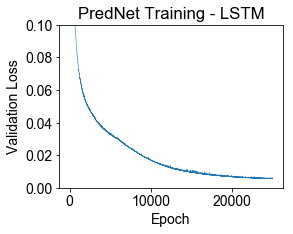

In [53]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 14

plt.plot(val_loss.detach(), linewidth = 0.5)
plt.ylim([0, .1])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('PredNet Training - LSTM')

plt.savefig('Figures/{}_PredNet_Loss.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [54]:
val_loss[-1]

tensor(0.0056, grad_fn=<SelectBackward>)

In [11]:
val_loss

tensor([1.2025, 0.8406, 0.5707,  ..., 0.0141, 0.0140, 0.0141],
       grad_fn=<CatBackward>)

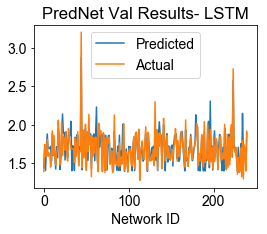

In [21]:
plt.figure(figsize = (4,3))
plt.xlabel('Network ID')
plt.plot(vl_val)
plt.plot(model(le_val).squeeze().detach())
plt.title('PredNet Val Results- LSTM')
plt.legend(['Predicted', 'Actual'])
plt.savefig('Figures/{}_PredNet_Val.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [13]:
test_model_type = 'gru'
test_data1 = torch.load('Correlation/{}_train.p'.format(test_model_type))
test_data2 = torch.load('Correlation/{}_val.p'.format(test_model_type))

In [22]:
loss_fn(model(test_data1[0]).squeeze(), test_data1[2])

tensor(18.0269, grad_fn=<MseLossBackward>)

In [15]:
loss_fn(model(test_data2[0]).squeeze(), test_data2[2])

tensor(13.2771, grad_fn=<MseLossBackward>)

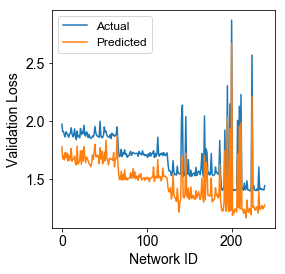

In [99]:
# plt.title('PredNet Val Results- LSTM')
plt.figure(figsize = (4,4))
plt.plot(vl_val[idx_val.sort()[1].tolist()])
plt.plot(model(le_val[idx_val.sort()[1].tolist()]).detach().numpy())
plt.xlabel('Network ID')
plt.ylabel('Validation Loss')
plt.legend(['Actual', 'Predicted'], prop = {'size':12})
plt.savefig('Figures/{}_PredNet_Val.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

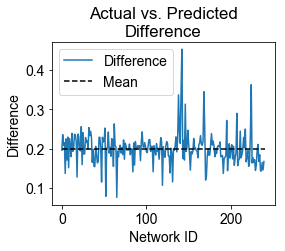

In [82]:
diff = vl_val[idx_val.sort()[1].tolist()] - model(le_val[idx_val.sort()[1].tolist()]).squeeze().detach()
plt.figure(figsize = (4,3))
plt.plot(diff)
plt.title('Actual vs. Predicted\nDifference')
plt.xlabel('Network ID')
plt.plot([0, 240], [diff.mean(), diff.mean()], 'k--')
plt.legend(['Difference', 'Mean'])
plt.ylabel('Difference')
plt.savefig('Figures/{}_PredNet_Error.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [17]:
torch.load('LE_stats/lstm_512_LEs.p').shape

torch.Size([300, 512])

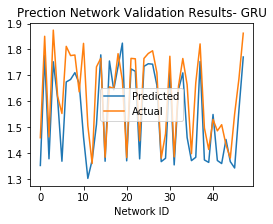

In [83]:
plt.figure(figsize = (4,3))
plt.xlabel('Network ID')
plt.plot(model(test_data2[0]).detach())
plt.plot(test_data2[2])
plt.title('Prection Network Validation Results- GRU')
plt.legend(['Predicted', 'Actual'])

In [11]:
ckpt = {'model_dict': model.state_dict(), 'optimizer_dict': optimizer.state_dict(), 'train_loss': train_loss, 'val_loss': val_loss}
torch.save(ckpt, 'Correlation/predNet.ckpt')

In [4]:
ckpt =  torch.load('Correlation/predNet.ckpt')
model.load_state_dict(ckpt['model_dict'])

<All keys matched successfully>

(0, 0.05)

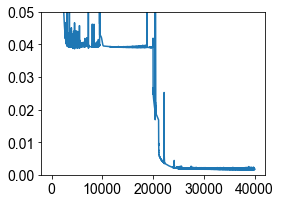

In [25]:
plt.plot(ckpt['val_loss'].detach())
plt.ylim(0, 0.05)

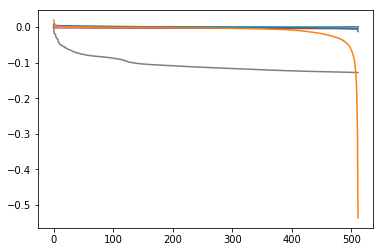

In [8]:
plt.plot(asrnn_data.t())

In [ ]:
plt.pcolor(a)
plt.colorbar()
plt.xlabel('LE Index')
plt.ylabel('Neuron ID')
plt.yticks([5, 10, 15, 20])
plt.title('PredNet Weights, Layer 1 [512x20]')

In [ ]:
c_product = torch.zeros((512, 20))
for idx in range(512):
    c_product[idx] = model[1](a.T[idx, :])*b[0]

In [ ]:
plt.plot(c_product.T[:, :])
plt.xlabel('Neuron ID')
plt.ylabel('Product Weight')
plt.xticks([5,10,15,20])

In [ ]:
model[1](a.T[0, :])

In [ ]:
plt.plot(a[[3], :].T, label = 'unit 3')
plt.plot(a[[4], :].T, label = 'unit 4')
plt.title('PredNet Layer 1 Weights')
plt.xlabel('LE Index')
plt.ylabel('Matrix Weight')
plt.legend()
plt.plot([0,512], [0,0], 'k-')

In [ ]:
model2 = torch.nn.Sequential(
    nn.Linear(512,20, bias = False),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1)
)

In [ ]:
plt.plot(model(le_val).squeeze().detach() - vl_val)
plt.ylabel('Prediction Error')
plt.title('Validation Set Losses')
plt.xlabel('Network ID')

In [38]:
fullTest = torch.load('Correlation/lstm_allLEs.p', map_location = torch.device('cpu'))

In [39]:
model(fullTest).squeeze()

tensor([1.7452, 1.7974, 1.7574,  ..., 1.2095, 1.2023, 1.2252],
       grad_fn=<SqueezeBackward0>)

In [33]:
fullValLoss = torch.load('Correlation/lstm_fullValLoss.p')

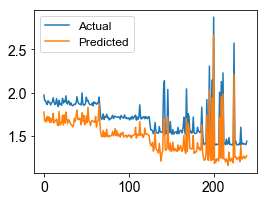

In [42]:
plt.figure(figsize = (4,3))
plt.plot(vl_val[idx_val.sort()[1].tolist()])
plt.plot(model(le_val[idx_val.sort()[1].tolist()]).detach().numpy())
plt.legend(['Actual', 'Predicted'], prop = {'size':12})


In [88]:
loss_fn(model(fullTest).squeeze(), fullValLoss)

tensor(0.0152, grad_fn=<MseLossBackward>)

In [90]:
torch.max(torch.abs(model(fullTest).squeeze()- fullValLoss))

tensor(0.3920, grad_fn=<MaxBackward1>)

In [57]:
model_type = 'lstm'
le_data = torch.load(f'Correlation/{model_type}_allLEs.p', map_location = torch.device('cpu'))
params = torch.load(f'Correlation/{model_type}_allParams.p',map_location = torch.device('cpu'))
val_losses = torch.load(f'Correlation/{model_type}_fullValLoss.p', map_location = torch.device('cpu'))

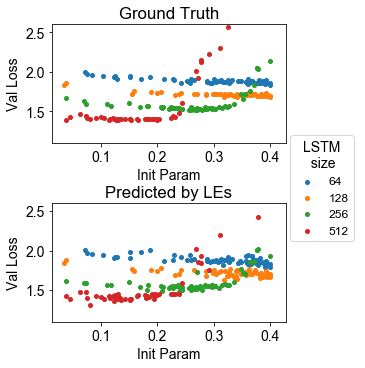

In [58]:
sizes = [64, 128, 256, 512]
evals = 300
fig = plt.figure(figsize = (4,5))
ax1 = fig.add_subplot(212)
for i in range(4): 
    idcs = ((idx_val_lstm.sort()[0] >= i*evals)*(idx_val_lstm.sort()[0] < (i+1)*evals)).tolist()
    ax1.scatter(params[idx_val_lstm.sort()[0][idcs].long()], model(le_data[idx_val_lstm.sort()[0][idcs].long()]).detach().numpy(), s = 16, label = sizes[i])
# ax1.legend(prop = {'size':12})
ax1.title.set_text('Predicted by LEs')
ax1.set_ylabel('Val Loss')
ax1.set_xlabel('Init Param')
ax2 = fig.add_subplot(211)
for i in range(4): 
    idcs = ((idx_val_lstm.sort()[0] >= i*evals)*(idx_val_lstm.sort()[0] < (i+1)*evals)).tolist()
    ax2.scatter(params[idx_val_lstm.sort()[0][idcs].long()], val_losses[idx_val_lstm.sort()[0][idcs].long()], s = 16, label = sizes[i])
# .legend(prop = {'size':12})
ax2.title.set_text('Ground Truth')
ax2.set_ylabel('Val Loss')
ax2.set_xlabel('Init Param')
# plt.ylabel('Predicted Val Loss')
ax1.set_ylim([1.1, 2.6])
ax2.set_ylim([1.1, 2.6])
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1, 0.5), 
                 loc="center left", borderaxespad=0.2, prop = {'size':12}, frameon = True)
lgd.set_title('LSTM\n  size')
plt.tight_layout(pad = 0.2)
plt.draw()
plt.savefig('Figures/{}_PredNet_Comp.png'.format(model_type), bbox_extra_artists = (lgd,), bbox_inches="tight",dpi=400, format = 'png')

In [59]:
model_type = 'gru'
le_data = torch.load(f'Correlation/{model_type}_allLEs.p', map_location = torch.device('cpu'))
params = torch.load(f'Correlation/{model_type}_allParams.p',map_location = torch.device('cpu'))
val_losses = torch.load(f'Correlation/{model_type}_fullValLoss.p', map_location = torch.device('cpu'))

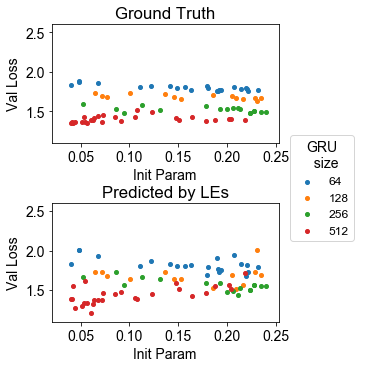

In [61]:
sizes = [64, 128, 256, 512]
evals = 100
fig = plt.figure(figsize = (4,5))
ax1 = fig.add_subplot(212)
for i in range(4): 
    idcs = ((idx_val_gru.sort()[0] >= i*evals)*(idx_val_gru.sort()[0] < (i+1)*evals)).tolist()
    ax1.scatter(params[idx_val_gru.sort()[0][idcs].long()], model(le_data[idx_val_gru.sort()[0][idcs].long()]).detach().numpy(), s = 16, label = sizes[i])
# ax1.legend(prop = {'size':12})
ax1.title.set_text('Predicted by LEs')
ax1.set_ylabel('Val Loss')
ax1.set_xlabel('Init Param')
ax2 = fig.add_subplot(211)
for i in range(4): 
    idcs = ((idx_val_gru.sort()[0] >= i*evals)*(idx_val_gru.sort()[0] < (i+1)*evals)).tolist()
    ax2.scatter(params[idx_val_gru.sort()[0][idcs].long()], val_losses[idx_val_gru.sort()[0][idcs].long()], s = 16, label = sizes[i])
# .legend(prop = {'size':12})
ax2.title.set_text('Ground Truth')
ax2.set_ylabel('Val Loss')
ax2.set_xlabel('Init Param')
# plt.ylabel('Predicted Val Loss')
ax1.set_ylim([1.1, 2.6])
ax2.set_ylim([1.1, 2.6])
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1, 0.5), 
                 loc="center left", borderaxespad=0.2, prop = {'size':12}, frameon = True)
lgd.set_title('GRU\n  size')
plt.tight_layout(pad = 0.2)
plt.draw()
plt.savefig('Figures/{}_PredNet_Comp.png'.format(model_type), bbox_extra_artists = (lgd,), bbox_inches="tight",dpi=400, format = 'png')

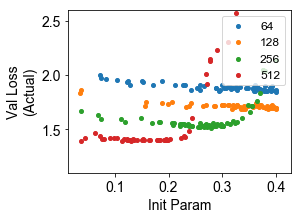

In [233]:
sizes = [64, 128, 256, 512]
evals = 300
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    plt.scatter(params[idx_val.sort()[0][idcs].long()], val_losses[idx_val.sort()[0][idcs].long()], s = 16, label = sizes[i])
plt.legend(prop = {'size':12})
plt.xlabel('Init Param')
plt.ylabel('Val Loss\n(Actual)')
plt.ylim([1.1, 2.6])
plt.savefig('Figures/{}_RealVal_v_Init.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

RuntimeError: invalid argument 13: ldc should be at least max(1, m=0), but have 0 at C:\w\1\s\tmp_conda_3.6_014803\conda\conda-bld\pytorch_1565315401686\work\aten\src\TH/generic/THBlas.cpp:367

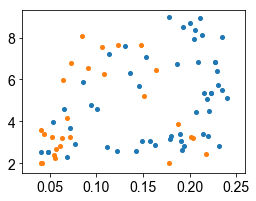

In [50]:
sizes = [64, 128, 256, 512]
evals = 300
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    plt.scatter(params[idx_val.sort()[0][idcs].long()], model(le_data[idx_val.sort()[0][idcs].long()]).detach().numpy(), s = 16, label = sizes[i])
plt.legend(prop = {'size':12})
plt.ylabel('Val Loss\n(Predicted)')
# plt.title('Actual Val Loss - LSTM')
plt.xlabel('Init Param')
plt.ylim([1.1, 2.6])
plt.savefig('Figures/{}_PredVal_v_Init.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [91]:
params[idx_val.sort()[0][idcs].long()]

tensor([0.0740, 0.0630, 0.1650, 0.1720, 0.0810, 0.0530, 0.1310, 0.1990, 0.1510,
        0.2260, 0.2100, 0.2040, 0.2320, 0.1860, 0.1600, 0.2150, 0.2360, 0.1940,
        0.2240, 0.2240, 0.1650])

In [88]:
idx_val.sort()[0][idcs].int()

tensor([ 2,  7,  8,  9, 11, 13, 18, 20, 36, 47, 48, 52, 58, 65, 68, 75, 76, 78,
        82, 88, 99], dtype=torch.int32)

In [83]:
len(idcs)

80

# Autoencoder

In [23]:
class AutoPred(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden = nn.Linear(in_features = kwargs['input_size'], out_features = kwargs['e_hidden'])
        self.encoder_out = nn.Linear(in_features = kwargs['e_hidden'], out_features = kwargs['encoded_size'])
        self.decoder_hidden = nn.Linear(in_features = kwargs['encoded_size'], out_features = kwargs['d_hidden'])
        self.decoder_out = nn.Linear(in_features = kwargs['d_hidden'], out_features = kwargs['input_size'])
        self.predictor = nn.Linear(in_features = kwargs['encoded_size'], out_features = 1)
        self.act = nn.LeakyReLU()
    
    def forward(self, features):
        #Encode
        activation = self.encoder_hidden(features)
        activation = torch.relu(activation)
        code = self.encoder_out(activation)
        code = self.act(code)
        #Predict
        predicted = self.predictor(code)
        predicted = self.act(predicted)
        #Decode
        activation = self.decoder_hidden(code)
        activation = torch.relu(activation)
        activation = self.decoder_out(activation)
        reconstructed = self.act(activation)
        return reconstructed, predicted

In [24]:
def objective(model, LEs, vls, alpha = 1):
    criterion = nn.MSELoss()
    LE_out, vl_pred = model(LEs)
    loss1 = criterion(LEs, LE_out)
    loss2 = criterion(vls, vl_pred.squeeze())
    loss = loss1 + alpha * loss2
    return loss

In [25]:
auto_model = AutoPred(input_size = 512, e_hidden = 150, encoded_size = 50, d_hidden = 150)
learning_rate = 0.0001
auto_optimizer = torch.optim.Adam(auto_model.parameters(), lr= learning_rate)

In [26]:
print(auto_model(le_train)[1].shape)
print(vl_train.shape)

torch.Size([960, 1])
torch.Size([960])


alpha = 5
0
100
200
300
400
500
600
700
800
900
alpha = 10
0
100
200
300
400
500
600
700
800
900
alpha = 20
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
alpha = 50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
alpha = 100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


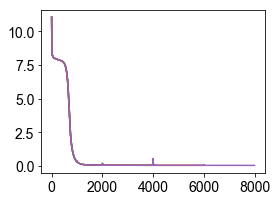

In [28]:
new = True
if new:
    auto_model = AutoPred(input_size = 512, e_hidden = 150, encoded_size = 50, d_hidden = 150)
    learning_rate = 0.0001
    auto_optimizer = torch.optim.Adam(auto_model.parameters(), lr= learning_rate)
    val_loss = torch.zeros(0)
    train_loss = torch.zeros(0)

    
epoch_list = [1000, 1000, 2000, 2000, 2000]
alphas = [5, 10, 20, 50, 100]
# epoch_list = [4000]
# alphas = [500]
idx_total = 0
for alpha, epochs in zip(alphas, epoch_list):
    print(f'alpha = {alpha}')
    for idx in range(epochs):
        idx_total += 1
        tloss =objective(auto_model, le_train, vl_train, alpha = alpha)
        train_loss = torch.cat((train_loss, tloss.unsqueeze(0)))

        auto_optimizer.zero_grad()
        tloss.backward()
        auto_optimizer.step()
        vloss = objective(auto_model, le_val, vl_val)
        val_loss = torch.cat((val_loss, vloss.unsqueeze(0)))
        if idx%100 == 0:
            print(idx)
    plt.plot(val_loss.detach())
plt.savefig('Figures/{}_AE_Training.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

tensor(0.0424, grad_fn=<SelectBackward>)


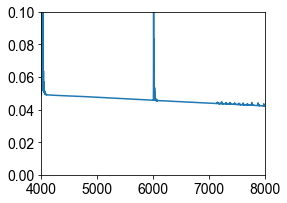

In [29]:
plt.plot(val_loss.detach())
plt.xlim([4000,8000])
plt.ylim([0, .1])
print(val_loss[-1])

Text(0, 0.5, 'LE Value')

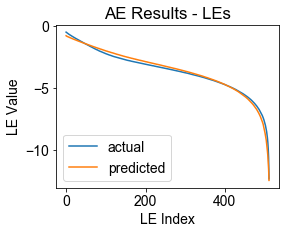

In [30]:
i = 2
plt.plot(le_train[i], label = 'actual')
plt.plot(auto_model(le_train[i])[0].detach(), label = 'predicted')
plt.legend()
plt.title('AE Results - LEs')
plt.xlabel('LE Index')
plt.ylabel('LE Value')

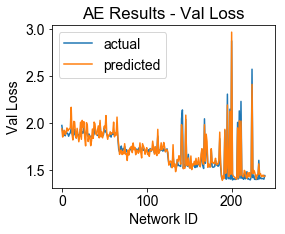

In [31]:
plt.plot(vl_val[idx_val.sort()[1].tolist()], label = 'actual')
plt.plot(auto_model(le_val)[1].detach()[idx_val.sort()[1].tolist()], label = 'predicted')
plt.legend()
plt.title('AE Results - Val Loss')
plt.xlabel('Network ID')
plt.ylabel('Val Loss')
plt.savefig('Figures/{}_AutoPred_VLs.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

In [16]:
le_data = torch.load(f'Correlation/{model_type}_allLEs.p', map_location = torch.device('cpu'))
params = torch.load(f'Correlation/{model_type}_allParams.p',map_location = torch.device('cpu'))
val_losses = torch.load(f'Correlation/{model_type}_fullValLoss.p', map_location = torch.device('cpu'))

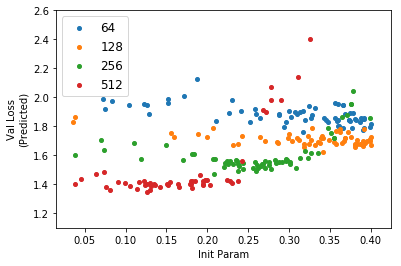

In [17]:
sizes = [64, 128, 256, 512]
evals = 300
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    plt.scatter(params[idx_val.sort()[0][idcs].long()], auto_model(le_data[idx_val.sort()[0][idcs].long()])[1].detach().numpy(), s = 16, label = sizes[i])
plt.legend(prop = {'size':12})
plt.ylabel('Val Loss\n(Predicted)')
# plt.title('Actual Val Loss - LSTM')
plt.xlabel('Init Param')
plt.ylim([1.1, 2.6])
plt.title
plt.savefig('Figures/{}_AutoPredVal_v_Init.png'.format(model_type), bbox_inches="tight",dpi=400, format = 'png')

IndexError: index 400 is out of bounds for dimension 0 with size 400

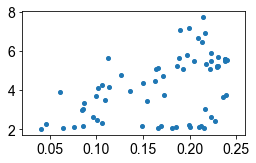

In [43]:
sizes = [64, 128, 256, 512]
evals = 300
fig = plt.figure(figsize = (4,5))
ax1 = fig.add_subplot(212)
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    ax1.scatter(params[idx_val.sort()[0][idcs].long()], auto_model(le_data[idx_val.sort()[0][idcs].long()])[1].detach().numpy(), s = 16, label = sizes[i])
# ax1.legend(prop = {'size':12})
ax1.title.set_text('Predicted by LEs')
ax1.set_ylabel('Val Loss')
ax1.set_xlabel('Init Param')
ax2 = fig.add_subplot(211)
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    ax2.scatter(params[idx_val.sort()[0][idcs].long()], val_losses[idx_val.sort()[0][idcs].long()], s = 16, label = sizes[i])
# .legend(prop = {'size':12})
ax2.title.set_text('Ground Truth')
ax2.set_ylabel('Val Loss')
ax2.set_xlabel('Init Param')
# plt.ylabel('Predicted Val Loss')
ax1.set_ylim([1.1, 2.6])
ax2.set_ylim([1.1, 2.6])
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1, 0.5), 
                 loc="center left", borderaxespad=0.2, prop = {'size':12}, frameon = True)
lgd.set_title('LSTM\n  size')
plt.tight_layout(pad = 0.2)
plt.draw()
plt.savefig('Figures/{}_AEPredNet_Comp.png'.format(model_type), bbox_extra_artists = (lgd,), bbox_inches="tight",dpi=400, format = 'png')

In [57]:
model_type = 'lstm'
le_val, tl_val, vl_val, param_val, idx_val = torch.load('Correlation/{}_val.p'.format(model_type))
le_data = torch.load(f'Correlation/{model_type}_allLEs.p', map_location = torch.device('cpu'))
params = torch.load(f'Correlation/{model_type}_allParams.p',map_location = torch.device('cpu'))
val_losses = torch.load(f'Correlation/{model_type}_fullValLoss.p', map_location = torch.device('cpu'))

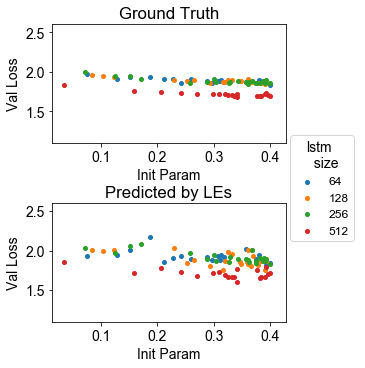

In [58]:
sizes = [64, 128, 256, 512]
evals = 100
fig = plt.figure(figsize = (4,5))
ax1 = fig.add_subplot(212)
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    ax1.scatter(params[idx_val.sort()[0][idcs].long()], auto_model(le_data[idx_val.sort()[0][idcs].long()])[1].detach().numpy(), s = 16, label = sizes[i])
# ax1.legend(prop = {'size':12})
ax1.title.set_text('Predicted by LEs')
ax1.set_ylabel('Val Loss')
ax1.set_xlabel('Init Param')
ax2 = fig.add_subplot(211)
for i in range(4): 
    idcs = ((idx_val.sort()[0] >= i*evals)*(idx_val.sort()[0] < (i+1)*evals)).tolist()
    ax2.scatter(params[idx_val.sort()[0][idcs].long()], val_losses[idx_val.sort()[0][idcs].long()], s = 16, label = sizes[i])
# .legend(prop = {'size':12})
ax2.title.set_text('Ground Truth')
ax2.set_ylabel('Val Loss')
ax2.set_xlabel('Init Param')
# plt.ylabel('Predicted Val Loss')
ax1.set_ylim([1.1, 2.6])
ax2.set_ylim([1.1, 2.6])
handles, labels = ax2.get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1, 0.5), 
                 loc="center left", borderaxespad=0.2, prop = {'size':12}, frameon = True)
lgd.set_title(f'{model_type}\n  size')
plt.tight_layout(pad = 0.2)
plt.draw()
# plt.savefig('Figures/{}_AEPredNet_Comp.png'.format(model_type), bbox_extra_artists = (lgd,), bbox_inches="tight",dpi=400, format = 'png')

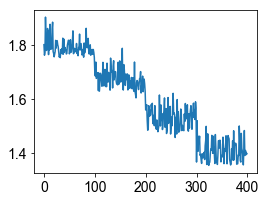

In [56]:
plt.plot(val_losses)